<a href="https://colab.research.google.com/github/MilanHassan/Python-Projects/blob/main/Image_classification_using_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import neccesary libraries**

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import cv2
from PIL import Image
import tensorflow 

from numpy.random import seed
seed(1337)
tensorflow.random.set_seed(42)

from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint
from keras import layers, models, Model, optimizers

from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

**Storing the path of the data into variables**

In [ ]:
train_data_dir = "/content/UNSEEN/train"
val_data_dir = "/content/UNSEEN/valid"
test_data_dir = "/content/UNSEEN/test"

**Transfer Learning using VGG16**

In [ ]:
img_height, img_width = 224,224
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Data Preprocessing - Resizing + Data augmentation**

In [ ]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range = (0.8,1.0),
        fill_mode='nearest')
        
        
       

test_datagen =  ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)



**Data Preprocessing**

In [ ]:
print('Total number of images for "training":')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")

print('Total number of images for "validation":')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=False)

print('Total number of images for "testing":')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=False)

Total number of images for "training":
Found 1260 images belonging to 6 classes.
Total number of images for "validation":
Found 270 images belonging to 6 classes.
Total number of images for "testing":
Found 17 images belonging to 6 classes.


Text(0.5, 1.0, 'Number of training images per category:')

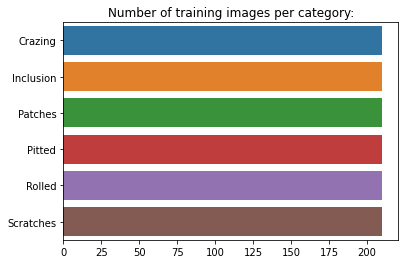

In [ ]:
category_names = sorted(os.listdir('/content/UNSEEN/train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = '/content/UNSEEN/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

**Plotting train images with their labels**

In [ ]:
def plots(ims, figsize=(16,16), rows=4, interp=False, titles=None):
  f = plt.figure(figsize=figsize)
  cols = len(ims)//rows if len(ims) & 2 ==0 else len(ims)//rows + 1
  for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('off')
    sp.set_title(class_names[titles[i].tolist().index(1)], fontsize=16)
    plt.imshow(ims[i])

In [ ]:
class_names = ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches'] 

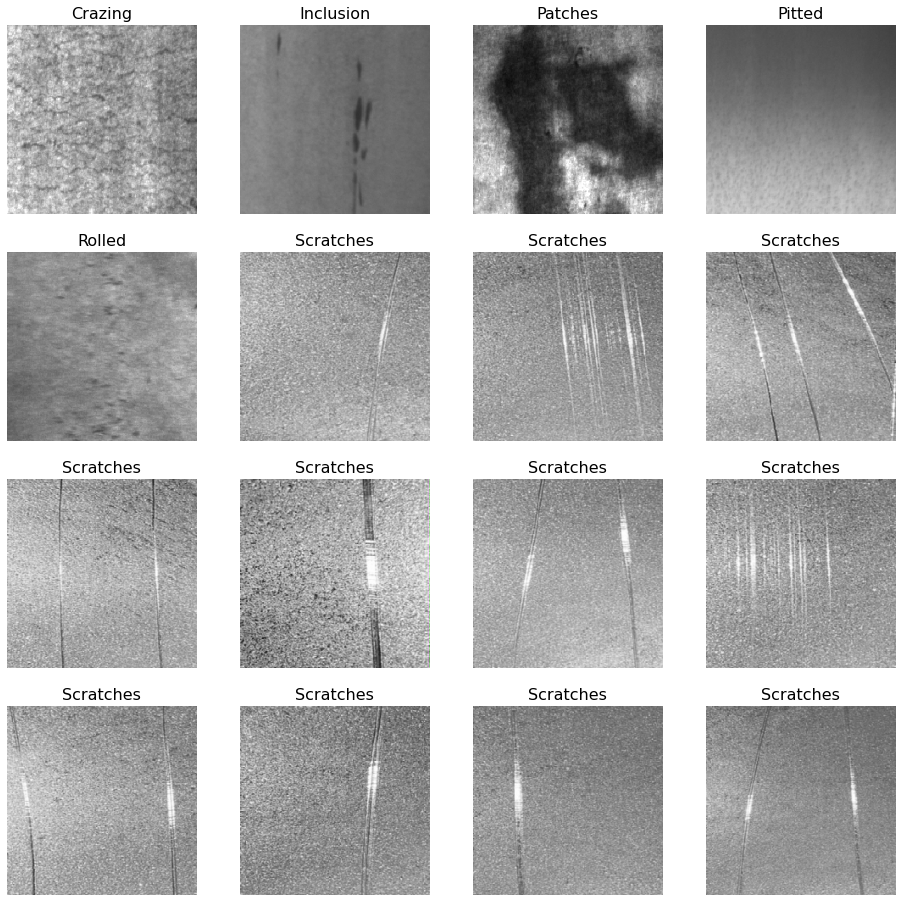

In [ ]:
imgs, labels = next(test_generator)
plots(imgs, titles=labels)

**Model Creation - Replacing Last Dense Layer with our own**

In [ ]:
for layer in conv_base.layers[:15]:
   layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 global_max_pooling2d_2 True


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

**Compiling and Training**

In [ ]:
learning_rate = 5e-5
epochs = 10
checkpoint = ModelCheckpoint("sign_classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])

In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=val_generator,
                              callbacks=[checkpoint] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
79/79 [==============================] - 25s 305ms/step - loss: 1.2959 - acc: 0.5028 - val_loss: 0.4773 - val_acc: 0.7889

Epoch 00001: val_acc improved from -inf to 0.78889, saving model to sign_classifier.h5
Epoch 2/10
79/79 [==============================] - 18s 232ms/step - loss: 0.1222 - acc: 0.9703 - val_loss: 0.2273 - val_acc: 0.9259

Epoch 00002: val_acc improved from 0.78889 to 0.92593, saving model to sign_classifier.h5
Epoch 3/10
79/79 [==============================] - 18s 231ms/step - loss: 0.0825 - acc: 0.9792 - val_loss: 0.1704 - val_acc: 0.9444

Epoch 00003: val_acc improved from 0.92593 to 0.94444, saving model to sign_classifier.h5
Epoch 4/10
79/79 [==============================] - 18s 233ms/step - loss: 0.0332 - acc: 0.9923 - val_loss: 0.1197 - val_acc: 0.9593

Epoch 00004: val_acc improved from 0.94444 to 0.95926, saving model to sign_classifier.h5
Epoch 5/10
79/79 [==============================] - 18s 230ms/step - loss: 0.0226 - acc: 0.9869 - val_loss:

**Visualize training results**

In [ ]:
model = models.load_model("sign_classifier.h5")

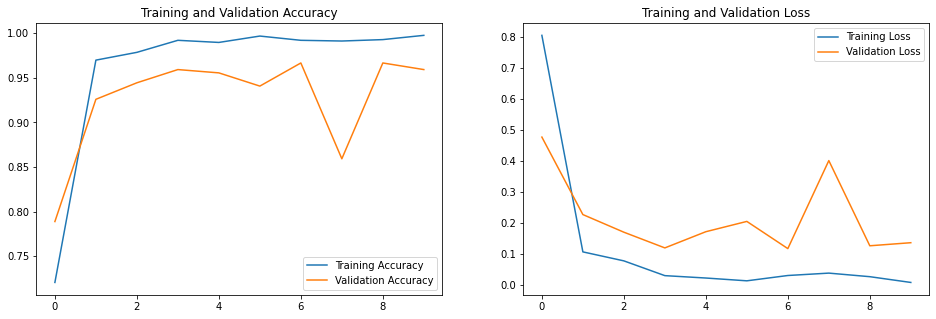

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Predict on test data**

In [ ]:
model.save('sign_classifier.h5')

In [ ]:
model.evaluate_generator(test_generator, steps=20)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.5453259944915771, 0.7058823704719543]

**Prediction on test data visualised**

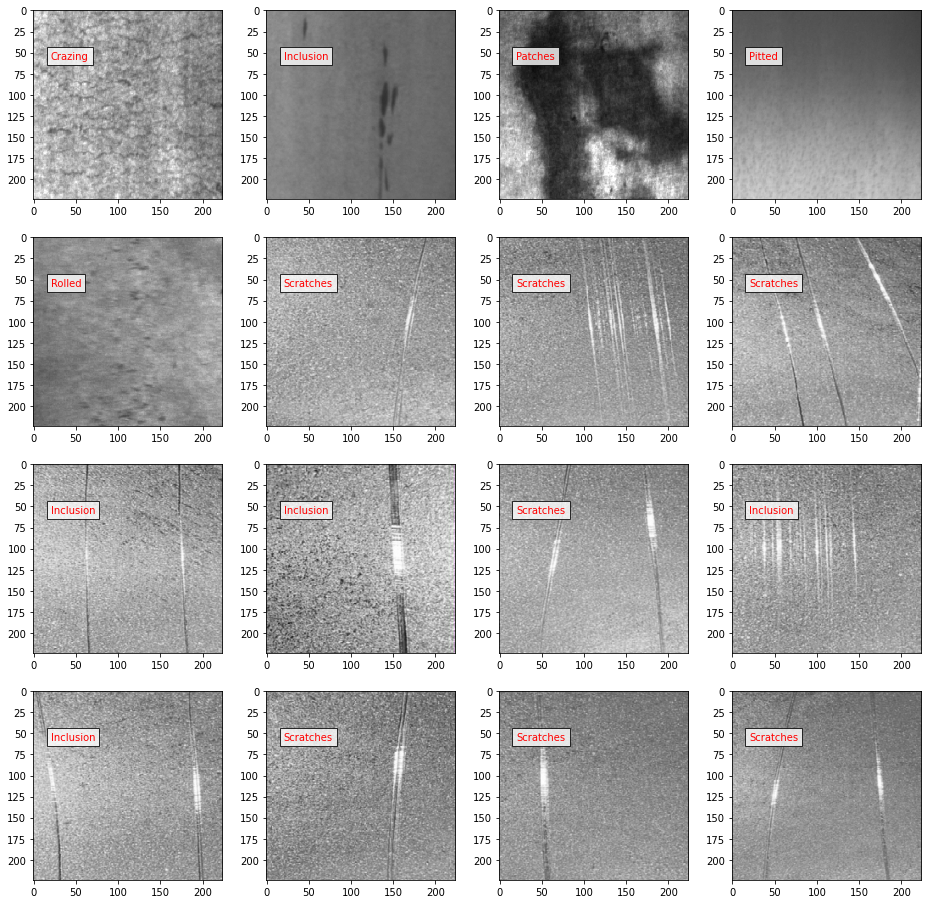

In [ ]:
imgs, labels = next(test_generator)
fig=plt.figure(figsize=(16,16))
columns = 4
rows = 4
for i in range(columns*rows):
  fig.add_subplot(rows, columns, i+1)
  img_t= np.expand_dims(imgs[i], axis=0)
  prediction = model.predict(img_t)
  idx = prediction[0].tolist().index(max(prediction[0]))
  plt.text(20, 58, class_names[idx], color= 'red', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
  plt.imshow(imgs[i])

**Plotting Confusion matrix**

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
target_names = []

for key in test_generator.class_indices:

    target_names.append(key)
print(target_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[0 1 2 3 4 5 5 5 1 1 5 1 1 5 5 5 1]
[0 1 2 3 4 5 5 5 5 5 5 5 5 5 5 5 5]
Confusion Matrix
Confusion matrix, without normalization


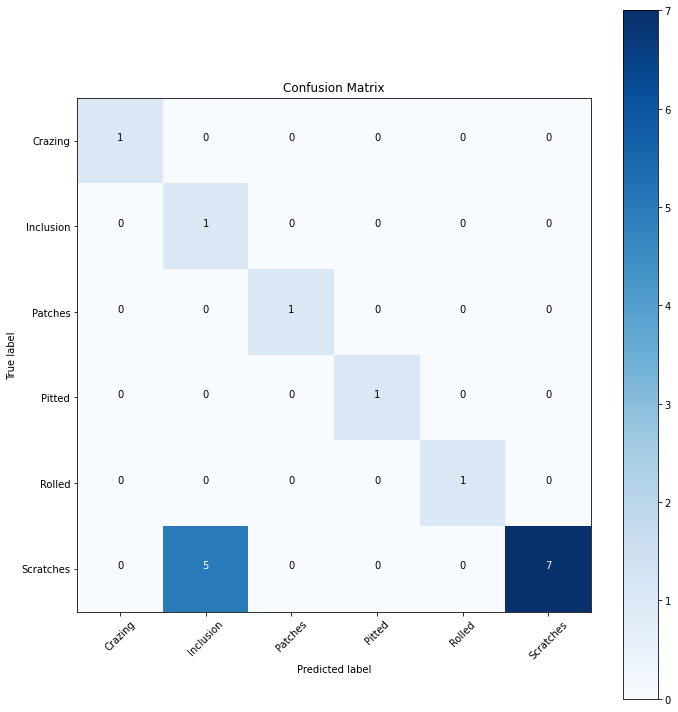

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools  
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#print(Y_pred[0])
print(test_generator.classes)
print('Confusion Matrix')

cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

**Plotting Classification Metrics**

In [ ]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00         1
   Inclusion       0.17      1.00      0.29         1
     Patches       1.00      1.00      1.00         1
      Pitted       1.00      1.00      1.00         1
      Rolled       1.00      1.00      1.00         1
   Scratches       1.00      0.58      0.74        12

    accuracy                           0.71        17
   macro avg       0.86      0.93      0.84        17
weighted avg       0.95      0.71      0.77        17

